# Detection simulations for SPA

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from julia import Main
import matplotlib.pyplot as plt
plt.style.use(['seaborn-deep', 'notebook'])
import numpy as np
import pandas as pd
import seaborn as sns
import sympy as smp
from sympy import Symbol, symbols
from tqdm.notebook import tqdm


import centrex_TlF as centrex
import trajectories
from SPA_utilities import run_traj_ensemble_simulation, bootstrap_frequency_scan

## Define states

In [2]:
# Define ground states
gnd = [centrex.states.QuantumSelector(J=0,  electronic='X'),
       centrex.states.QuantumSelector(J=2, electronic= 'X')]

# Define excited states
exc = [centrex.states.QuantumSelector(J=1, F=2, F1=3/2, electronic = 'B', P = -1)]

# Define ground and excited states for laser
gnd_laser = [centrex.states.QuantumSelector(J=0, F=1,  electronic='X')]
exc_laser = exc

## Define parameters for simulation
### System parameters

In [3]:
syspars = centrex.states.SystemParameters(
    nprocs  = 11,
    Γ       = 2*np.pi*1.56e6,
    ground  = gnd,
    excited = exc
)

### Parameters for Bloch Equations

In [4]:
odepars = centrex.lindblad.odeParameters(
    # Laser  properties
    Ωl = "Ωl0 * phase_modulation(t, β, ωphase) * gaussian_2d(vz*t, y0+vy*t, 1., z0laser, y0laser, σzlaser, σylaser)", 
    Ωl0     = 1*syspars.Γ,    # Peak Rabi frequency of the laser [rad/s]
    δl      = 0.0,            # detuning of the laser [rad/s]
    
    # Coordinates for center of laser intensity distribution
    z0laser = 0.0,
    y0laser = 0.,
    
    # Laser intensity distribution width
    σzlaser = 1.3e-3/4 * np.sqrt(2), # Std dev for Gaussian Rabi rate distribution of laser along direction of 
                                     # flight of molecules (m)
    σylaser = 5*1.3e-3/4 * np.sqrt(2), # Std dev for Gaussian Rabi rate distribution of along up-down direction (m)
    
    # Laser phase modulation
    ωphase = syspars.Γ,       # laser phase modulation frequency [rad/s]
    β      = 3.8,             # laser phase modulation depth [rad]
    
    # laser polarization switching
    ωp = 0,           # polarization switching frequency [rad/s]
    φp = 0.0,         # polarization switching phase [rad]
    Pl  = 1.,
    Plz = 1.,
    Plx = 0.,
    Ply = 0.0,
    
    # Molecules
    y0 = 0.,                   # molecule start y position [m]
    vz = 184.,                 # longitudinal molecular velocity [m/s]
    vy = 0.,                   # molecule vy [m/s]
)

## Define transitions

In [5]:
transitions = [
    centrex.couplings.TransitionSelector(
        ground = 1*centrex.states.generate_coupled_states_ground_X(gnd_laser),
        excited = 1*centrex.states.generate_coupled_states_excited_B(exc_laser),
        polarizations        = [[0,0,1],[1,0,0],[0,1,0]],
        polarization_symbols = symbols("Plz     Plx     Ply"),
        Ω = smp.Symbol('Ωl', complex = True),
        δ = smp.Symbol('δl'),
        description = "R(0), F' = 2",        
    ),
]

## Define optical Bloch equations

In [6]:
obe_system = centrex.lindblad.setup_OBE_system_julia(syspars, odepars, transitions, verbose=True, full_output=True,
                                                    qn_compact=centrex.states.QuantumSelector(J=2, electronic = 'X'))

[14:36:31] INFO     generate_OBE_system: 1/6 -> Generating the reduced     ]8;id=275599;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=222521;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py#133\133]8;;\
                    Hamiltonian                                                              

[14:36:34] INFO     generate_OBE_system: 2/6 -> Generating the couplings   ]8;id=413334;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=201763;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py#150\150]8;;\
                    corresponding to the transitions                                         

[14:36:38] INFO     generate_OBE_system: 3/6 -> Generating the symbolic    ]8;id=633744;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=984189;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py#185\185]8;;\
                    Hamiltonian                                                              

[14:36:39] INFO     generate_OBE_system: 4/6 -> Generating the collapse    ]8;id=902549;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=74968;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py#196\196]8;;\
                    matrices                                                                 

           INFO     generate_OBE_system: 5/6 -> Transforming the           ]8;id=768372;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=642644;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py#225\225]8;;\
                    Hamiltonian and collapse matrices into a symbolic                        
                    system of equations                                                      

           INFO     generate_OBE_system: 6/6 -> Generating Julia code      ]8;id=924621;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=130365;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py#233\233]8;;\
                    representing the system of equations                                     

[14:36:47] INFO     setup_OBE_system_julia: 1/3 -> Generating the preamble ]8;id=914190;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=39691;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py#311\311]8;;\

           INFO     setup_OBE_system_julia: 2/3 -> Initializing Julia on   ]8;id=142567;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=690248;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py#315\315]8;;\
                    11 cores                                                                 

Initialized Julia with 11 processes


[14:38:52] INFO     setup_OBE_system_julia: 3/3 -> Defining the ODE        ]8;id=820379;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=159259;file://c:\users\oskari\documents\github\centrex-tlf\centrex_TlF\lindblad\utils_setup.py#322\322]8;;\
                    equation and parameters in Julia                                         

### Set peak Rabi rate based on laser power

In [7]:
Ωl0 = centrex.utils.light.calculate_rabi_from_power_gaussian_beam(
                        30e-3,
                        obe_system.couplings[0]['main coupling'],
                        odepars.σzlaser,
                        odepars.σylaser
    ).real
print(f"Peak Rabi rate is {Ωl0/syspars.Γ:.1f}Γ")

odepars.Ωl0 = np.abs(Ωl0)

Peak Rabi rate is 2.3Γ


### Define initial populations

In [8]:
init_states_selector = centrex.states.QuantumSelector(J=0, F=1,  electronic='X')

ρ = centrex.utils.generate_population_states(
                    init_states_selector.get_indices(obe_system.QN), 
                    len(obe_system.QN)
)

### Define time range for simulations

In [9]:
delta_z = 10*odepars.σzlaser
delta_t = delta_z/odepars.vz
t_range = (-delta_t/2, delta_t/2)

## Single Trajectory

In [10]:
# %%timeit
t_array, results = centrex.lindblad.do_simulation_single(odepars, t_range, ρ)

In [11]:
laser_intensity = np.abs(odepars.get_parameter_evolution(t_array, "Ωl"))

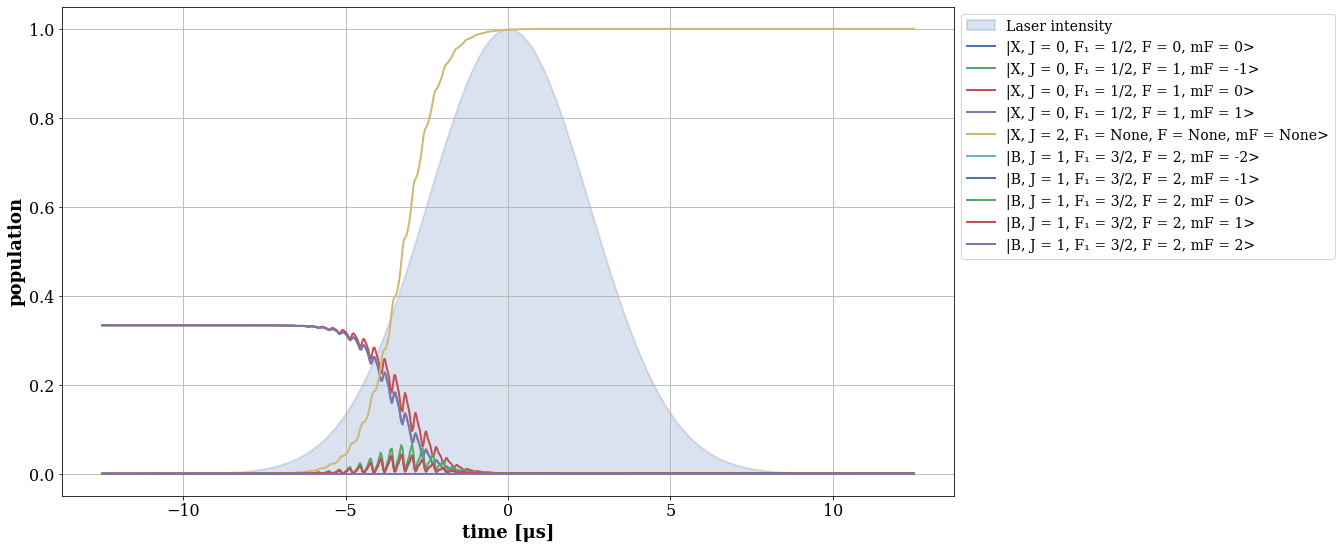

In [12]:
fig, ax = plt.subplots() 
ax.fill_between(t_array*1e6, laser_intensity/laser_intensity.max(), lw = 2, color = 'C0',
        label = 'Laser intensity', alpha = 0.2)
for r, s in zip(results, obe_system.QN):
    s = s.find_largest_component()
    # label = f"|{s.electronic_state}, J={s.J}, F1={s.F1}, F={s.F}, mF={s.mF}"
    label = s.state_string(short=True)
    ax.plot(t_array*1e6, r, lw = 2, label = label)
ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14, bbox_to_anchor = (1.,1.))
ax.grid(True)

In [13]:
np.trapz(results[exc[0].get_indices(obe_system.QN),:].sum(axis = 0), t_array)*syspars.Γ

1.9152032567249433

## Detuning scan
### With phase modulation

In [14]:
%%time
odepars.ωphase = 1*syspars.Γ
odepars.β = 3.8


# Define values for detunings
δl_scan = np.linspace(-40,40,201)*2*np.pi*1e6

# Define scan parameter
parameters = ["δl"]
values = [δl_scan]

# Function for calculating the output from the simulation (number of photons)
output_func = centrex.lindblad.setup_state_integral_calculation(
                states = exc[0].get_indices(obe_system.QN, mode = "julia"),
                nphotons = True
            )

# Callback function that stops the simulation
cb = centrex.lindblad.setup_discrete_callback_terminate(odepars, "vz*t >= 0.01")

# Setup problem
ens_prob = centrex.lindblad.setup_problem_parameter_scan(
                        odepars, t_range, ρ, parameters, values, 
                        dimensions = 1,
                        output_func = output_func,
                        zipped = True
            )

centrex.lindblad.solve_problem_parameter_scan(ensemble_problem_name = ens_prob, saveat = 1e-7,
                                             callback = cb)

Wall time: 30 s


Text(0.5, 0, 'Detuning / MHz')

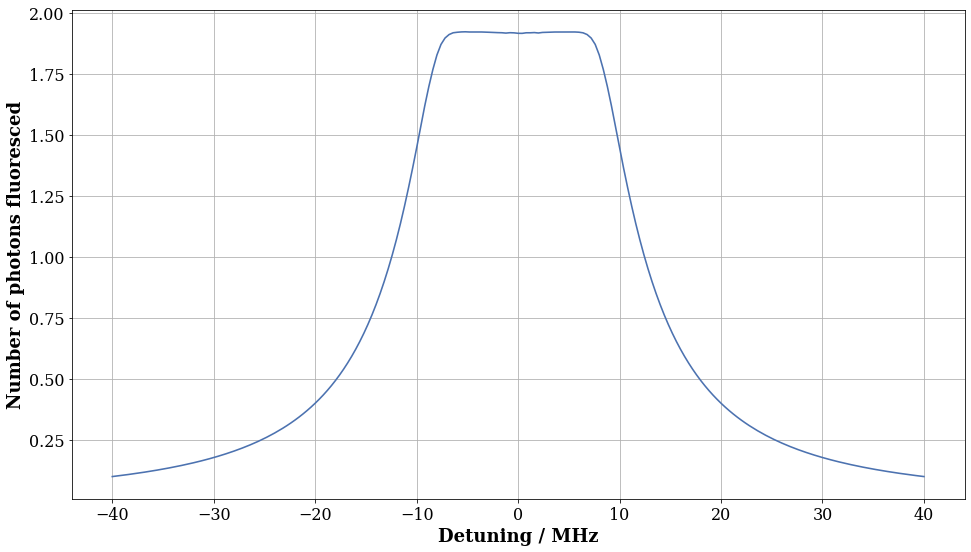

In [15]:
results = centrex.lindblad.get_results_parameter_scan()

fig, ax = plt.subplots()
ax.plot(δl_scan/(2*np.pi*1e6), results, '-')
ax.grid(True)
ax.set_ylabel('Number of photons fluoresced')
ax.set_xlabel('Detuning / MHz')

### No phase modulation

In [16]:
%%time
odepars.ωphase = 0

# Define values for detunings
δl_scan = np.linspace(-40,40,101)*2*np.pi*1e6

# Define scan parameter
parameters = ["δl"]
values = [δl_scan]

# Function for calculating the output from the simulation (number of photons)
output_func = centrex.lindblad.setup_state_integral_calculation(
                states = exc[0].get_indices(obe_system.QN, mode = "julia"),
                nphotons = True
            )

# Callback function that stops the simulation
cb = centrex.lindblad.setup_discrete_callback_terminate(odepars, "vz*t >= 0.01")

# Setup problem
ens_prob = centrex.lindblad.setup_problem_parameter_scan(
                        odepars, t_range, ρ, parameters, values, 
                        dimensions = 1,
                        output_func = output_func,
                        zipped = True
            )

centrex.lindblad.solve_problem_parameter_scan(ensemble_problem_name = ens_prob, saveat = 1e-7,
                                             callback = cb)

Wall time: 6.19 s


Text(0.5, 0, 'Detuning / MHz')

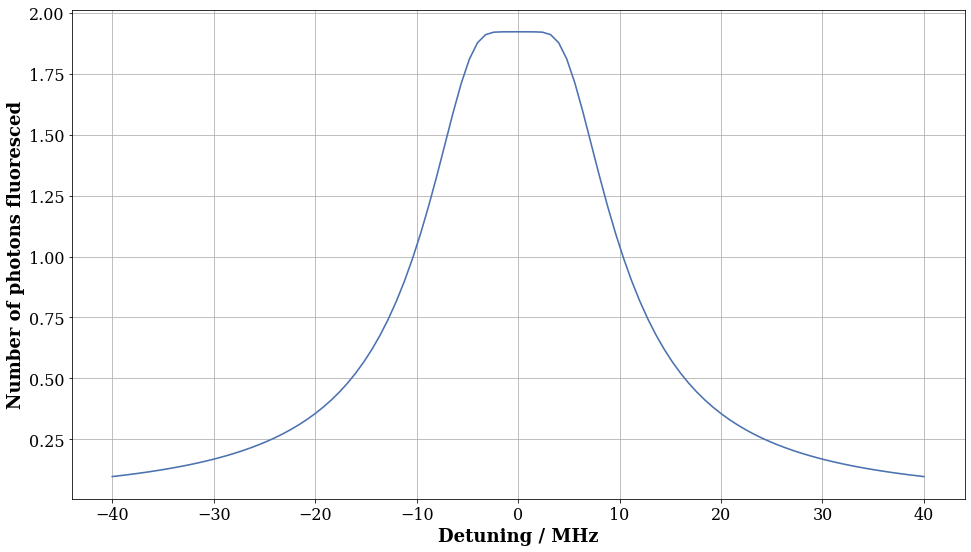

In [17]:
results = centrex.lindblad.get_results_parameter_scan()
fig, ax = plt.subplots()
ax.plot(δl_scan/(2*np.pi*1e6), results, '-')
ax.grid(True)
ax.set_ylabel('Number of photons fluoresced')
ax.set_xlabel('Detuning / MHz')

## Frequency scan for trajectory ensemble

### Load trajectories from file

In [18]:
filepath = Path("C:/Users/Oskari/Documents/GitHub/centrex-molecule-trajectories/saved_data/SPA_pos_vel_distr.hdf")
run_name = "SPA position distributions - apertures - ACME ini pos - 5-16-2022 - 1e9"
result_trajectories = trajectories.utils.import_sim_result_from_hdf(filepath, run_name, n_traj=10000)

Importing trajectories...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 892.61it/s]


### Find positions and velocities just before detection

#### Positions

Determining radial positions...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 37694.29it/s]


Text(0.5, 0, 'Y-position / mm')

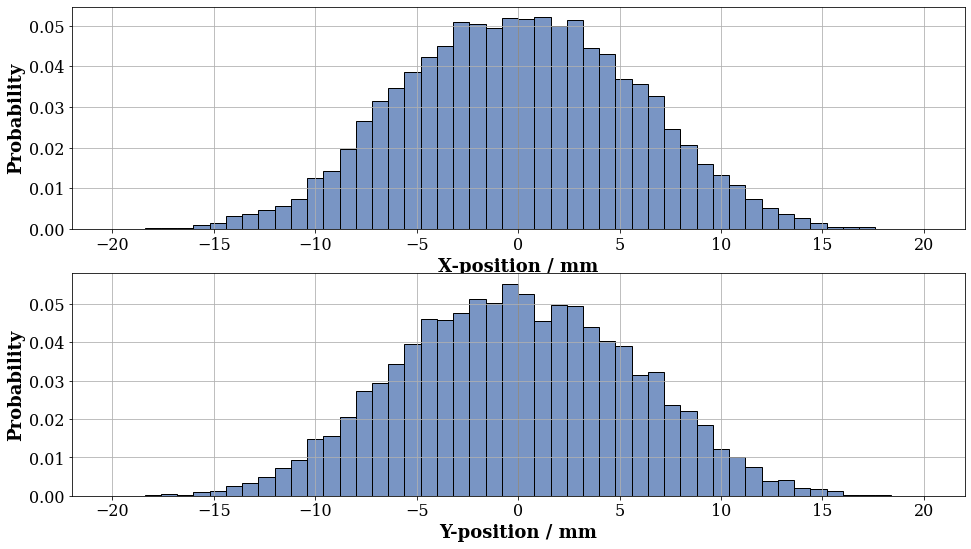

In [19]:
# Define z-position of the detection region
z = result_trajectories.beamline.find_element('laser').z0 - 5*odepars.σzlaser

# Find radial positions
rho = trajectories.post_processing.find_radial_pos_dist(result_trajectories, z, elements=['Detected'])

# Make a dataframe
df_rho = pd.DataFrame({'x':rho[:,0], 'y':rho[:,1]})
df_rho['x_mm'] = df_rho.x*1e3
df_rho['y_mm'] = df_rho.y*1e3


# Plot histograms of position as check
fig, (ax, ax1) = plt.subplots(2,1, figsize=(16, 9))
ax = sns.histplot(data = df_rho, x = 'x_mm', stat = 'probability', kde = False, bins = np.linspace(-20, 20, 51),
                 ax = ax)
ax.set_xlabel("X-position / mm")

ax1 = sns.histplot(data = df_rho, x = 'y_mm', stat = 'probability', kde = False, bins = np.linspace(-20, 20, 51),
                   ax = ax1)
ax1.set_xlabel("Y-position / mm")

#### Velocities

Determining radial velocities...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 53333.94it/s]


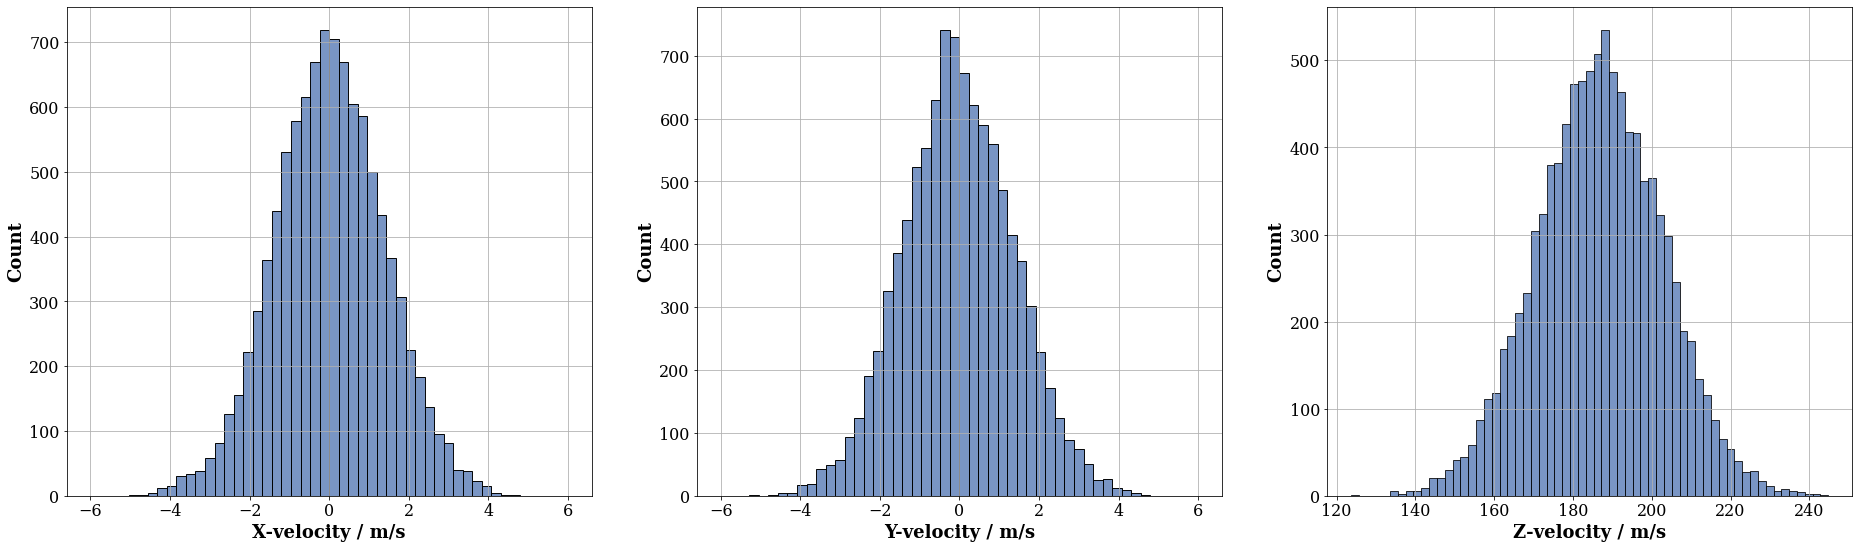

In [20]:
vs = trajectories.post_processing.find_vel_dist(result_trajectories, z)
df_v = pd.DataFrame({'vx':vs[:,0], 'vy':vs[:,1], 'vz':vs[:,2]})

fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize=(32, 9))
ax3 = sns.histplot(data = df_v, x = 'vz', stat = 'count', kde = False, ax = ax3, )
ax3.set_xlabel("Z-velocity / m/s")
ax.set_xlabel("X-velocity / m/s")
ax2.set_xlabel("Y-velocity / m/s")

ax = sns.histplot(data = df_v, x = 'vx', stat = 'count', kde = False, ax = ax, bins = np.linspace(-6, 6, 51))
ax2 = sns.histplot(data = df_v, x = 'vy', stat = 'count', kde = False, ax = ax2, bins = np.linspace(-6, 6, 51))


#### Merge position and velocity

In [21]:
df_traj = df_rho.merge(df_v, left_index = True, right_index = True)

#### Calculate Doppler shifts

In [22]:
df_traj['doppler'] = 2*np.pi*df_traj.vx/271.7e-9

#### Calculate amount of time that needs to be simulated

In [23]:
df_traj['delta_t'] = 10*odepars.σzlaser/df_traj.vz

### Run simulation

In [25]:
%%time
# Define number of trajectories
ntraj = 100

# Set parameters for the simulation
odepars.ωphase = 1*syspars.Γ
odepars.z0laser = 5*odepars.σzlaser

# Define laser detunings
laser_detunings = np.linspace(-40,40, 101)*2*np.pi*1e6

df_traj_ens = run_traj_ensemble_simulation(df_traj, odepars, obe_system, exc, ρ,"R(0),_F'=2", laser_detunings = laser_detunings, n_traj = ntraj)

Wall time: 18.8 s


In [26]:
df_traj_ens['laser_detuning_MHz'] = df_traj_ens.laser_detuning/(2*np.pi*1e6)

In [27]:
mean_photons = df_traj_ens.groupby('laser_detuning').mean().reset_index()
mean_photons['laser_detuning_MHz'] = mean_photons.laser_detuning/(2*np.pi*1e6)

Text(0, 0.5, 'Mean number of photons\nper molecule')

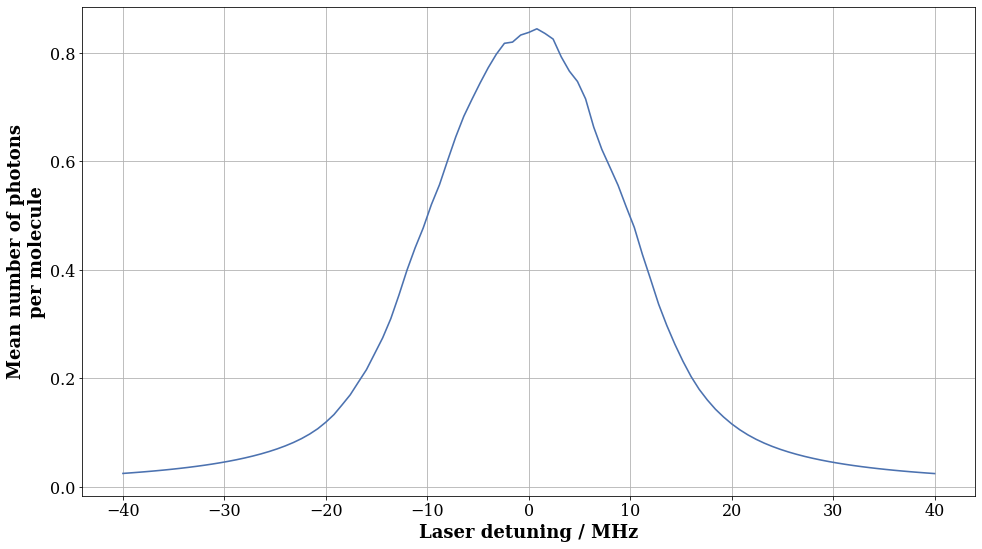

In [28]:
ax = sns.lineplot(data = mean_photons, x = 'laser_detuning_MHz', y = 'n_photons')
ax.set_xlabel('Laser detuning / MHz')
ax.set_ylabel('Mean number of photons\nper molecule')

## Bootstrapped simulation

In [29]:
%%time
# Define number of trajectories and bootstraps
ntraj = 100
n_bs = 100

# Set parameters for the simulation
odepars.ωphase = 1*syspars.Γ
odepars.z0laser = 5*odepars.σzlaser

# Define laser detunings
laser_detunings = np.linspace(-40,40, 101)*2*np.pi*1e6

df_agg, df_bs = bootstrap_frequency_scan(df_traj, odepars, obe_system, exc, ρ,"R(0),_F'=2", laser_detunings = laser_detunings, n_traj = ntraj, n_bs = n_bs, save = True)

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 28min 48s


Text(0, 0.5, 'Mean number of photons\nper molecule')

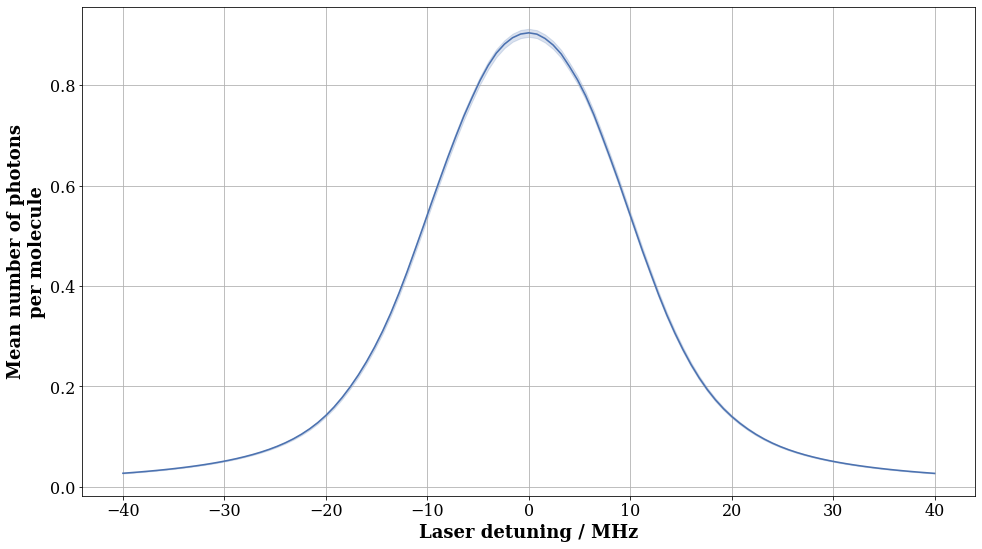

In [30]:
df_agg['detuning_MHz'] = df_agg.laser_detuning/(2*np.pi*1e6)
fig, ax = plt.subplots()
ax.plot(df_agg.detuning_MHz, df_agg.n_photons['mean'], color = 'C0')
ax.fill_between(df_agg.detuning_MHz, df_agg.n_photons['mean']-df_agg.n_photons['sem'], df_agg.n_photons['mean']+df_agg.n_photons['sem'], color = 'C0', alpha = 0.2)
ax.set_xlabel('Laser detuning / MHz')
ax.set_ylabel('Mean number of photons\nper molecule')

In [33]:
transition_name = "R(0),F'=2"
time = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
fname = f"./saved_data/{transition_name}_bs_agg_n={ntraj*n_bs}_{time}.csv"
with open(fname,'w+', encoding="utf-8") as f:
    f.write(odepars.__repr__()+'\n',)
    df_agg.to_csv(f, index=False)
    
fname = f"./saved_data/{transition_name}_bs_n={ntraj*n_bs}_{time}.csv"
with open(fname,'w+', encoding="utf-8") as f:
    f.write(odepars.__repr__()+'\n',)
    df_bs.to_csv(f, index=False)

In [6]:
df_bs = pd.read_csv("./saved_data/R(0),F'=2_bs_n=10000_2022-05-19_16-30-33.csv", skiprows=1)